<a href="https://colab.research.google.com/github/YuriiKlim/AI/blob/Neural_lesson2/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Імпорт модулів

In [370]:
import torch
import pandas as pd
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

Дані медичне страхування

In [371]:
# трохи обробки даних
df = pd.read_csv('https://raw.githubusercontent.com/HalyshAnton/IT-Step-Pyton-AI/main/module3/data/insurance.csv')

df['sex'] = df['sex'].map({'male': 0, 'female':1})
df['smoker'] = df['smoker'].map({'no': 0, 'yes':1})

df = df.drop(columns=['region'])

data = df[['age', 'bmi', 'expenses']]
df[['age', 'bmi', 'expenses']] = (data - data.min()) / (data.max() - data.min())

In [372]:
df

,age,sex,bmi,children,smoker,expenses
0,0.021739,1,0.320755,0,1,0.251611
1,0.000000,0,0.479784,1,0,0.009636
2,0.217391,0,0.458221,3,0,0.053115
3,0.326087,0,0.180593,0,0,0.333010
4,0.304348,0,0.347709,0,0,0.043816
...,...,...,...,...,...,...
1333,0.695652,0,0.404313,3,0,0.151299
1334,0.000000,1,0.428571,0,0,0.017305
1335,0.000000,1,0.563342,0,0,0.008108
1336,0.065217,1,0.264151,0,0,0.014144


Потрібно на основі інформації людини спрогнозувати розмір її страховки `expenses`

# Завдання 1
Створіть клас Dataset

In [373]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, X, y):
      self.X = torch.FloatTensor(X.values).to(device)
      self.y = torch.FloatTensor(y.values).to(device)
      self.y = self.y.reshape(-1, 1)

    def __len__(self):
      return len(self.X)

    def __getitem__(self, idx):
      return self.X[idx], self.y[idx]

# Create dataset object
X = df.drop(columns=['expenses'])
y = df['expenses']

dataset = MyDataset(X, y)

# Завдання 2
Створіть DataLoader. Перевірте розміри даних в першому пакеті. Розмір пакетів оберіть самостійно

In [374]:
from torch.utils.data import DataLoader

batch_size = 256
dataloader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        generator=torch.Generator(device=device))

In [375]:
X_batch, y_batch = next(iter(dataloader))

In [376]:
X_batch.shape

torch.Size([256, 5])

In [377]:
y_batch.shape

torch.Size([256, 1])

In [378]:
X_batch.device

device(type='cuda', index=0)

# Завдання 3
Створіть нейромережу:
* Кількість шарів оберіть між 1-5
* Виберіть різні функції активації: Relu, LeakyRelu, Swish
* Кілкість нейронів у прихованих шарах повинна **не зростати**

In [379]:
from torch import nn, optim

class Model(nn.Module):
    def __init__(self, input_size=2, hidden_sizes=[4], output_size=1):
        super(Model, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))

        for i in range(len(hidden_sizes) - 1):
            self.layers.append(nn.LeakyReLU())
            self.layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))

        self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

model = Model(input_size=5, hidden_sizes=[7], output_size=1)

model

Model(
  (layers): ModuleList(
    (0): Linear(in_features=5, out_features=7, bias=True)
    (1): ReLU()
    (2): Linear(in_features=7, out_features=1, bias=True)
  )
)

In [380]:
from torchsummary import summary

summary(model, input_size=(5,))

Layer (type:depth-idx)                   Param #
├─ModuleList: 1-1                        --
|    └─Linear: 2-1                       42
|    └─ReLU: 2-2                         --
|    └─Linear: 2-3                       8
Total params: 50
Trainable params: 50
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─ModuleList: 1-1                        --
|    └─Linear: 2-1                       42
|    └─ReLU: 2-2                         --
|    └─Linear: 2-3                       8
Total params: 50
Trainable params: 50
Non-trainable params: 0

# Завдання 4
Визначте функцію втрат та оптимізатор

In [381]:
loss_fn = nn.MSELoss()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.99)

# Завдання 5
Натренуйте нейромережу. візміть невелику кількість епох

In [382]:
num_epochs = 200
losses = []

for epoch in range(num_epochs):
    losses_ = []
    for X_batch, y_batch in dataloader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        losses_.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    losses.append(np.mean(losses_))

    if epoch % 20 == 0 or epoch == num_epochs -1:
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss={losses[-1]}')

Epoch 1/200, Loss=0.0660591572523117
Epoch 21/200, Loss=0.017224757932126522
Epoch 41/200, Loss=0.012543644135197004
Epoch 61/200, Loss=0.009330098905290166
Epoch 81/200, Loss=0.009388239743808905
Epoch 101/200, Loss=0.008813822098697225
Epoch 121/200, Loss=0.008955806648979584
Epoch 141/200, Loss=0.00854815806572636
Epoch 161/200, Loss=0.008499488700181246
Epoch 181/200, Loss=0.008217365791400274
Epoch 200/200, Loss=0.008460353206222257


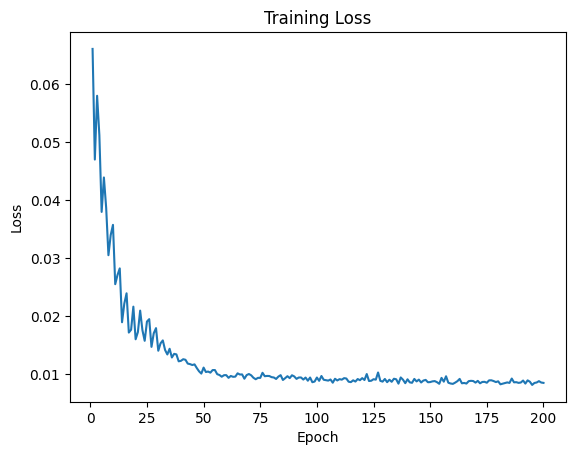

In [383]:
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs + 1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [384]:
X.iloc[:1]

,age,sex,bmi,children,smoker
0,0.021739,1,0.320755,0,1


In [385]:
X_data = torch.FloatTensor(X.iloc[:1].values)
X_data = X_data.to(device)

print(X_data)
print(X_data.shape)

tensor([[0.0217, 1.0000, 0.3208, 0.0000, 1.0000]], device='cuda:0')
torch.Size([1, 5])


# Завдання 6
Збережіть нейромережу та зробіть прогноз

In [386]:
torch.save(model, 'model.pt')

In [387]:
load_model = torch.load('model.pt')

In [388]:
load_model(X_data)

tensor([[0.3585]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [389]:
with torch.no_grad():
  print(load_model(X_data))

tensor([[0.3585]], device='cuda:0')
